In [ ]:
!pip install -q opencv-python tensorflow
import os, cv2, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import json

In [ ]:
drive.mount('/content/drive', force_remount=True)
DATA_FOLDER = '/content/drive/MyDrive/LandMark Images Pre-Processed'

Mounted at /content/drive


In [ ]:
# Locations of landmarks from my image dataset
LOCATION_MAP = {
    "Adam's Peak": "Rathnapura, Sabaragamuwa Province, Sri Lanka",
    "Ancient City of Polonnaruwa": "Polonnaruwa, North Central Province, Sri Lanka",
    "Beruwala Light House": "Beruwala, Western Province, Sri Lanka",
    "British War Cemetery": "Kandy, Central Province, Sri Lanka",
    "Bundala National Park": "Hambantota, Southern Province, Sri Lanka",
    "Delft Island": "Jaffna, Northern Province, Sri Lanka",
    "Dowa Rock Temple": "Bandarawela, Uva Province, Sri Lanka",
    "Ganagaramaya Temple": "Colombo, Western Province, Sri Lanka",
    "Henarathgoda Botanical Gard": "Gampaha, Western Province, Sri Lanka",
    "Hortains Plain": "Nuwara Eliya, Central Province, Sri Lanka",
    "Independance Square": "Colombo, Western Province, Sri Lanka",
    "Jaya Sri Maha Bodhi": "Anuradhapura, North Central Province, Sri Lanka",
    "Lotus Tower": "Colombo, Western Province, Sri Lanka",
    "Maligawa Buddha Statue": "Kandy, Central Province, Sri Lanka",
    "Nine Arches Bridge": "Ella, Uva Province, Sri Lanka",
    "Pinnawala Elephant Orphanage": "Kegalle, Sabaragamuwa Province, Sri Lanka",
    "Sigiriya": "Matale, Central Province, Sri Lanka",
    "Sinharaja Forest": "Ratnapura, Sabaragamuwa Province, Sri Lanka",
    "Sri Dalada Maligawa": "Kandy, Central Province, Sri Lanka",
    "Star Fort": "Matara, Southern Province, Sri Lanka",
    "Turtle Hatchery": "Kosgoda, Southern Province, Sri Lanka",
    "Vavuniya Archaeological Museum": "Vavuniya, Northern Province, Sri Lanka",
    "Wilapattu National Park": "Puttalam, North Western Province, Sri Lanka",
    "Yapahuwa Rock Fortress": "Yapahuwa, North Western Province, Sri Lanka",
}

In [ ]:
# Loading the image data
def load_images():
    X, y = [], []
    classes = sorted([d for d in os.listdir(DATA_FOLDER) if os.path.isdir(os.path.join(DATA_FOLDER, d))])

    for i, name in enumerate(classes):
        path = os.path.join(DATA_FOLDER, name)
        for file in os.listdir(path):
            if file.lower().endswith('.jpg'):
                try:
                    img = np.array(Image.open(os.path.join(path, file)).convert('RGB'))
                    X.append(cv2.resize(img, (290, 290)) / 255.0)
                    y.append(i)
                except:
                    pass

    # Stratified split to maintain class balance
    X_train, X_val, y_train, y_val = train_test_split(
        np.array(X), np.array(y),
        test_size=0.2,
        random_state=42,
        stratify=np.array(y)  # Ensures each landmark has 80/20 split
    )

    return X_train, X_val, y_train, y_val, classes

In [ ]:
X_train, X_val, y_train, y_val, CLASS_NAMES = load_images()
print(f"Loaded {len(X_train)} train, {len(X_val)} val images")

Loaded 384 train, 97 val images


Phase 01: Frozen base regularized to avoid overfitting and to improve the acuuracy

In [ ]:
# SIMPLIFIED PHASE 1 MODEL
base = tf.keras.applications.MobileNetV2(
    input_shape=(290, 290, 3),
    include_top=False,
    weights='imagenet'
)
base.trainable = False

inputs = layers.Input(shape=(290, 290, 3))
x = base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)  # Add this for stability

# Correct order: Dropout -> Dense -> Output
x = layers.Dropout(0.8)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.000995))(x)
outputs = layers.Dense(len(CLASS_NAMES), activation='softmax')(x)  # ONLY ONE OUTPUT

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

/tmp/ipython-input-3790513546.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 290, 290, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,039 (9.27 MB)

 Trainable params: 169,495 (662.09 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [ ]:
history_phase1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=24,
    batch_size= 25,
    callbacks=[EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss')],
    verbose=1
)

Epoch 1/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.0638 - loss: 5.3287 - val_accuracy: 0.1340 - val_loss: 3.3298
Epoch 2/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1688 - loss: 3.7562 - val_accuracy: 0.2577 - val_loss: 3.0019
Epoch 3/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.2624 - loss: 3.2569 - val_accuracy: 0.3196 - val_loss: 2.7400
Epoch 4/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4138 - loss: 2.4267 - val_accuracy: 0.3608 - val_loss: 2.5098
Epoch 5/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4506 - loss: 1.9746 - val_accuracy: 0.4227 - val_loss: 2.3245
Epoch 6/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5085 - loss: 1.9117 - val_accuracy: 0.4948 - val_loss: 2.1415
Epoch 7/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5998 - loss: 1.5487 - val_accuracy: 0.5876 - val_loss: 1.9933
Epoch 8/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5817 - loss: 1.5295 - val_accuracy: 0.6082 - val_loss:

Visualization: Checking for overfitting

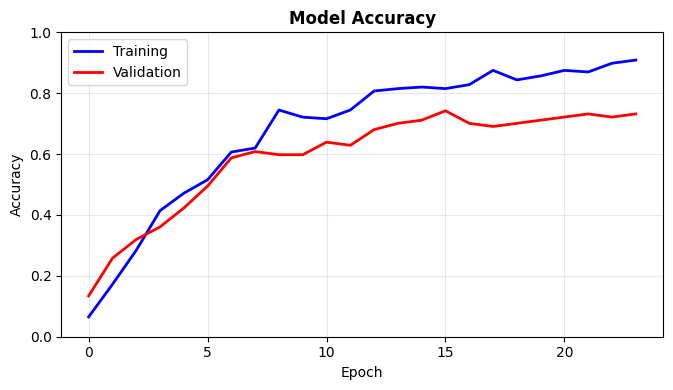

In [ ]:
plt.figure(figsize=(13, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_phase1.history['accuracy'], 'b-', label='Training', linewidth=2)
plt.plot(history_phase1.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
plt.title('Model Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
print("The model is slightly overfitting due to the pre augmented dataset")

The model is slightly overfitting due to the pre augmented dataset


In [ ]:
# Print final metrics
final_train_acc = history_phase1.history['accuracy'][-1]
final_val_acc = history_phase1.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.2%}")
print(f"Final Validation Accuracy: {final_val_acc:.2%}")
print(f"Gap: {final_train_acc - final_val_acc:.2%} ")


Final Training Accuracy: 90.89%
Final Validation Accuracy: 73.20%
Gap: 17.69% 


In [ ]:
# This function returns the landmark name and its location
def predict(img_path):
    img = Image.open(img_path).convert('RGB')
    img_array = cv2.resize(np.array(img), (290, 290)) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred_idx = np.argmax(model.predict(img_array, verbose=0)[0])
    landmark = CLASS_NAMES[pred_idx]
    location = LOCATION_MAP.get(landmark, "Unknown")

    return {'name': landmark, 'place': location}

In [ ]:
# Testing the model
result = predict('/content/drive/MyDrive/LandMark Images Pre-Processed/British War Cemetery/pic-2_png.rf.35f63c3dc54896480db9fee09a06f54b.jpg')
print(f"Landmark: {result['name']}")
print(f"Location: {result['place']}")


Landmark: British War Cemetery
Location: Kandy, Central Province, Sri Lanka


In [ ]:
model.save('/content/drive/MyDrive/LandmarkRecognition_model.keras')
print("✅ Model saved")

✅ Model saved


In [ ]:
# Save class names
with open('/content/drive/MyDrive/class_names.json', 'w') as f:
    json.dump(CLASS_NAMES, f)
print("Class names saved")

Class names saved
